In [1]:
from metavision_ml.preprocessing import histo
import numpy as np
from common import helpers


reader = helpers.load_evts_from_file(input("raw File: ")).reader
height, width = reader.get_size()
# Parameters
tbins = 50  # Number of time bins
start_ts = 1 * 1e6
reader.seek_time(start_ts)  # seek in the file to 1s

delta_t = 50000 #sampling duration
events = reader.load_delta_t(delta_t)  # load 50 milliseconds worth of events
events['t'] -= int(start_ts) # important! almost all preprocessing use relative time!
volume = np.zeros((tbins, 2, height, width), dtype=np.float32)


# Assuming 'events' is your list/array of events
histo(events, volume, delta_t)


C:\Program Files\Prophesee\lib\python3\site-packages\metavision_core_ml\preprocessing\viz.py:41: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _viz_events(events, img):


In [2]:
from scipy.fft import rfft, rfftfreq

# Corrected sampling rate calculation
sampling_rate = 1e6 / (delta_t / tbins)  # Convert microseconds to seconds

# The size of the rFFT output for each time bin sequence
fft_size = tbins // 2 + 1

# Initialize the fft_results array with the correct shape
fft_results = np.zeros((fft_size, 2, height, width), dtype=np.complex64)

# Perform FFT on each spatial cell
for x in range(width):
    for y in range(height):
        for polarity in range(2):  # Assuming 2 polarities
            fft_results[:, polarity, y, x] = rfft(volume[:, polarity, y, x])

# Calculate magnitudes
magnitudes = np.abs(fft_results)

# Find the maximum magnitude
max_magnitude = np.max(magnitudes)

# Normalize magnitudes between 0 and 1
normalized_magnitudes = magnitudes / max_magnitude

# Get the positive frequency components
frequencies = rfftfreq(tbins, d=1/sampling_rate)



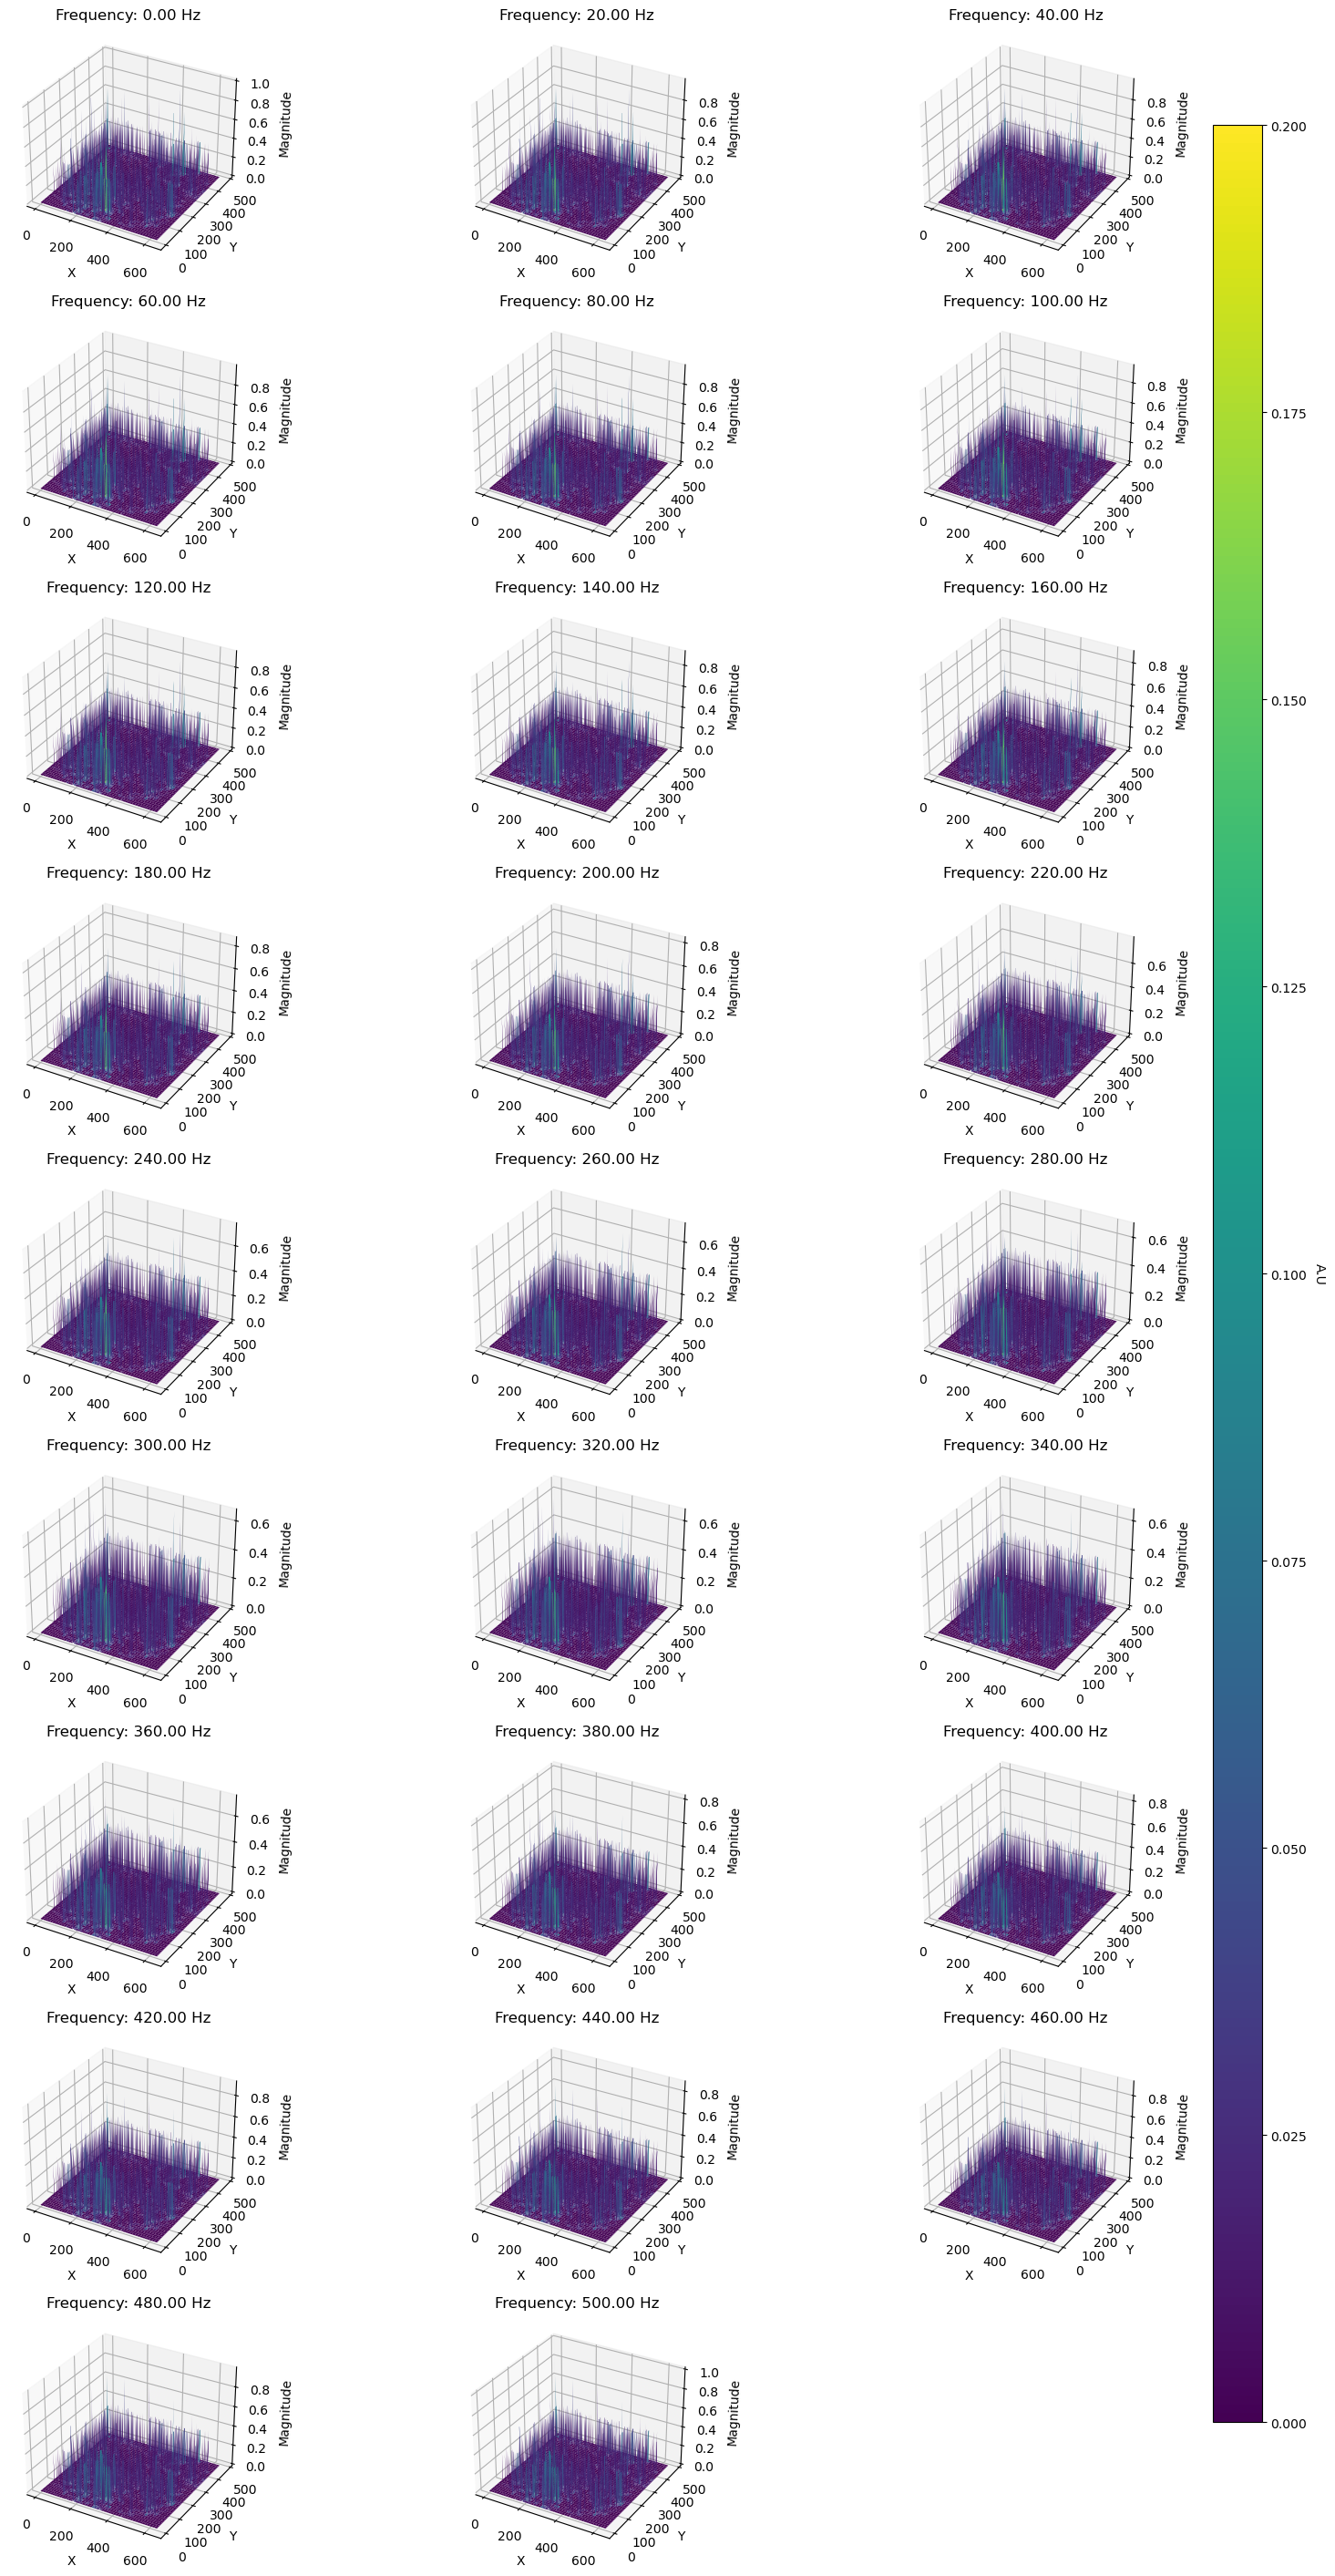

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

epsilon = 1e-6
log_magnitudes = np.log(normalized_magnitudes + epsilon)
# Determine the number of subplots needed
num_frequencies = len(frequencies)
cols = 3  # You can adjust the number of columns as needed
rows = num_frequencies // cols + (num_frequencies % cols > 0)

# Create a figure for the subplots
fig = plt.figure(figsize=(cols * 6, rows * 4))  # Adjust the figure size as needed

# Iterate over each positive frequency for plotting
for freq in range(num_frequencies):
    ax = fig.add_subplot(rows, cols, freq + 1, projection='3d')
    ax.set_title(f'Frequency: {frequencies[freq]:.2f} Hz')

    # Create a meshgrid for the spatial dimensions
    x = np.arange(width)
    y = np.arange(height)
    X, Y = np.meshgrid(x, y)

    # Get normalized magnitude for the current frequency
    Z = normalized_magnitudes[freq, 0, :, :]  # Assuming you're interested in one polarity

     
    
    # Plot
    surf = ax.plot_surface(X, Y, Z, cmap='viridis', vmin=0, vmax=0.2)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Magnitude')

# Add a single colorbar for the entire figure
cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])  # Adjust the position as needed
cbar = fig.colorbar(surf, cax=cbar_ax)
cbar.set_label('A.U', rotation=270, labelpad=15)

plt.show()

In [45]:
volume

array([[[[0. , 0. , 0. , ..., 0. , 0. , 0. ],
         [0. , 0. , 0. , ..., 0. , 0. , 0. ],
         [0. , 0. , 0. , ..., 0. , 0. , 0. ],
         ...,
         [0. , 0. , 0. , ..., 0. , 0. , 0. ],
         [0. , 0. , 0. , ..., 0. , 0. , 0. ],
         [0. , 0. , 0. , ..., 0. , 0. , 0. ]],

        [[0. , 0. , 0. , ..., 0. , 0. , 0. ],
         [0. , 0. , 0. , ..., 0. , 0. , 0. ],
         [0. , 0. , 0. , ..., 0. , 0. , 0. ],
         ...,
         [0. , 0. , 0. , ..., 0. , 0. , 0. ],
         [0. , 0. , 0. , ..., 0. , 0. , 0. ],
         [0. , 0. , 0. , ..., 0. , 0. , 0. ]]],


       [[[0. , 0. , 0. , ..., 0. , 0. , 0. ],
         [0. , 0. , 0. , ..., 0. , 0. , 0. ],
         [0. , 0. , 0. , ..., 0. , 0. , 0. ],
         ...,
         [0. , 0.2, 0.2, ..., 0. , 0. , 0. ],
         [0. , 0. , 0.2, ..., 0. , 0. , 0. ],
         [0. , 0. , 0. , ..., 0. , 0. , 0. ]],

        [[0. , 0. , 0. , ..., 0. , 0. , 0. ],
         [0. , 0. , 0. , ..., 0. , 0. , 0. ],
         [0. , 0. , 0. , ..., 